In [1]:
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization, Concatenate, LeakyReLU
from tensorflow.keras.utils import  to_categorical, Sequence
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import RandomNormal
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint 

In [2]:
import cv2, glob
import skimage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
from IPython.display import clear_output


In [3]:
WEIGHTS_FOLDER = './model/'
if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

In [4]:
df_celeb = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')

In [5]:
df_celeb.shape

(202599, 41)

In [6]:
df_celeb.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [7]:
def show_sample_image(nb=3, df=df_celeb, verbose=True):
    '''
        Function picks random faces from the celebrity dataset, 
        It plots the faces and returns the last one including its metadata
        Args:
         df: dataframe with celebrity faces' metadata
         nb: number of faces to display
         verbose: if False, do not display the faces, only return the last face chosen.
        Output
         - an image of the last celebrity face selected
         - the metadata of the last celebrity face selected
    '''
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, df.shape[0]-1)
        img_id = df.loc[idx].image_id
        img_uri = '../input/celeba-dataset/img_align_celeba/img_align_celeba/' + img_id
        img = skimage.io.imread(img_uri)  
        if verbose:
            label = img_id
            for col in df.columns:
                if df.loc[idx][col]==1:
                    label = label + '\n' + col  
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(label)
            else:
                ax.imshow(img) 
                ax.set_title(label)
        
    return img, list(df.loc[idx][1:df.shape[1]])

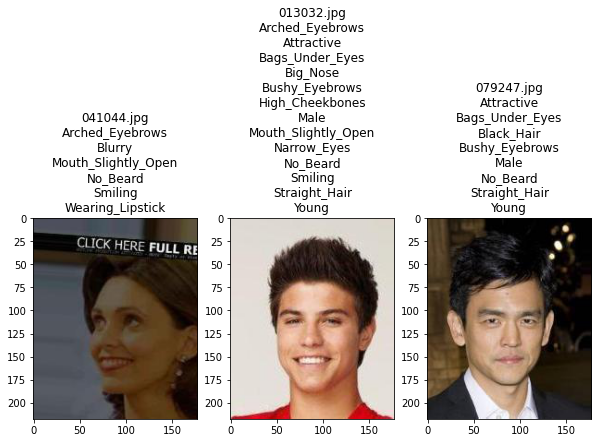

In [8]:
sample_img, sample_img_meta = show_sample_image()


In [9]:
print('The images are {}px height, {}px width with {} color channels.'.format(sample_img.shape[0],sample_img.shape[1],sample_img.shape[2]))


The images are 218px height, 178px width with 3 color channels.


In [10]:
class CustomCelebrityFaceGenerator(Sequence):
    def __init__(self, df, batch_size, target_height, target_width, conditioning_dim=0):
        '''
        This function intializes the custom celebrity face generator.
        
        Args:
            df: dataframe of image filenames and attributes.
            batch_size: batchsize.
            target_height: target image height. Images are resized to this height.
            target_width: target image width. Images are resized to this width.
            conditioning_dim: number of metadata point describing each face. 0 if no conditioning is used.
        '''
        self.df = df
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim

    def on_epoch_end(self):
        # we shuffle the images after each epoch, by shuffling the dataframe.
        self.df = self.df.sample(frac=1)
        
    def __getitem__(self, index):
        # we select the current batch from the shuffled dataframe
        cur_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]#.reset_index().drop(columns=['index'])
        # we create tensors used to train the network in the current epoch
        X, y = self.__data_generation(cur_files)
        return X, y
    
    def __data_generation(self, cur_files):
        # we initialize the 4d tensors  
        # with shape (number of images in the batch, # of pixels in height, # of pixels in width, # of channels) 
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        # if we use face metadata (conditional VAE), then we create an additional C tensor 
        # to store the conditioning variables
        if self.conditioning_dim > 0:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        # We fill the tensors by looping over the dataframe containing the images in the current batch 
        for i in range(0, self.batch_size):
            file = cur_files.iloc[i]
            img_uri = '../input/celeba-dataset/img_align_celeba/img_align_celeba/' + file.image_id
            img = skimage.io.imread(img_uri)
            # if the actual image shape is different that the network's image shape, we resize
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) 
            img = img.astype(np.float32) / 255.
            X[i] = img
            Y[i] = img
            # for conditioning we save the metadata from the dataframe into a tensor
            if self.conditioning_dim > 0:
                C[i] = list(file[1:file.shape[0]])
            
        if self.conditioning_dim > 0:
            return [X, C], Y
        else:
            return X, Y
    
    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

In [11]:
def get_encoder_network(x, num_filters):  
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x


In [12]:
def get_decoder_network(x, num_filters):
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x


In [13]:
def get_vae(height, width, batch_size, latent_dim, is_variational=True, conditioning_dim=0,
               start_filters=8, nb_capacity=3, optimizer=Adam(lr=0.001)):
    """
    
    Defines an autoencoder network.
    
    Arguments:
        is_variational: if True, a variational autoencoder is created using sampling.
        height: face image height in pixel.
        width: face image width in pixel.
        batch_size: batch size.
        latent_dim: latent space dimension.
        conditioning_dim: zero for an unconditional VAE.
        start_filters: number of filters used in the convolutional layers.
        nb_capacity: number of times the filters are doubled to increase capacity
        optimizer: optimizer to be used during training
        
    Output:
        encoder neural network, decoder neural network, full VAE network.
    """
    
    ### INPUT 
    #########
    
    # the image metadata are concatenated to the image pixel values to create the conditioning input
    # the Keras layer below is created for this purpose
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    ### ENCODER
    ############
    
    # we increase the capacity of the encoder network by duplicating the layers with increasing filters
    eblock = get_encoder_network(inputs_new, start_filters)
    for i in range(1, nb_capacity+1):
        eblock = get_encoder_network(eblock, start_filters*(2**i))
        
    
    _, *shape_spatial = eblock.get_shape().as_list()
    eblock_flat = Flatten()(eblock)
    
    if not is_variational:
        z = Dense(latent_dim)(eblock_flat)
    else:
        # function for sampling latent values for a normal distribution
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock_flat)
        z_log_sigma = Dense(latent_dim)(eblock_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    ### DECODER
    ############
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock.shape.as_list()[1:])(embedding)
    
    # we increase the capacity of the decoder network
    dblock = get_decoder_network(embedding, start_filters*(2**nb_capacity))
    for i in range(nb_capacity-1, -1, -1):
        dblock = get_decoder_network(dblock, start_filters*(2**i))
        
    output = Conv2D(3, 1, activation = 'tanh')(dblock)
    
    ### VAE
    ########
    decoder = Model( inputs_embedding,   output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model([inputs, condition], z)
        encoder_with_sampling_ext = Model( [inputs, condition], z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model( [inputs, condition], vae_out)
    else:
        encoder_with_sampling = Model( inputs, z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model( inputs,vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        # VAE loss is the sum of MSE and KL-divergence loss
        mse_loss = K.mean(mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
        
    if is_variational:
        vae.compile(loss=vae_loss, optimizer=optimizer)
    else:
        vae.compile(loss='mse', optimizer=optimizer)    
        
    print('Our VAE network has ', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder


In [14]:
VARIATIONAL = True # we want a variational autoencoder
HEIGHT = 128 # we want to reduce the images to 128px height during training
WIDTH = 128 # we want to reduce the images to 128px width during training
BATCH_SIZE = 16 # we set the batch size to 16 images
LATENT_DIM = 16 # we set the latent space to dimension 16
START_FILTERS = 32 # we have convolutional layers with 32, 64, 128 filters
CAPACITY = 3 
CONDITIONING = True # we consider the images metadata
OPTIMIZER = Adam(lr=0.01)


In [15]:
vae, encoder, decoder = get_vae(is_variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=df_celeb.shape[1]-1, 
                                   start_filters=START_FILTERS,
                                   nb_capacity=CAPACITY,
                                   optimizer=OPTIMIZER)


2022-06-09 10:12:46.523657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 10:12:46.608026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 10:12:46.608782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 10:12:46.609937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Our VAE network has  5063811 parameters.


In [16]:
vae.load_weights('../input/vaetrained/vae.w')
encoder.load_weights('../input/encodertrained/encoder.w')
decoder.load_weights('../input/decodertrained/decoder.w')


In [17]:
vae_json = vae.to_json()
with open("model/vae.json", "w") as json_file:
    json_file.write(vae_json)
encoder_json = encoder.to_json()
with open("model/encoder.json", "w") as json_file:
    json_file.write(encoder_json)
decoder_json = decoder.to_json()
with open("model/decoder.json", "w") as json_file:
    json_file.write(decoder_json)


In [18]:
gen = CustomCelebrityFaceGenerator(df_celeb, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)
early_stopping = EarlyStopping(monitor='loss',min_delta=0,patience=5,verbose=1, mode='auto')

In [19]:
msk = np.random.rand(len(df_celeb)) < 0.5
df_celeb_train = df_celeb[msk]
df_celeb_val = df_celeb[~msk]
df_celeb_train.shape, df_celeb_val.shape

((101129, 41), (101470, 41))

In [20]:
gen = CustomCelebrityFaceGenerator(df_celeb_train, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)
gen_val = CustomCelebrityFaceGenerator(df_celeb_val, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)


In [21]:
json_file = open('model/vae.json', 'r')
vae_json = json_file.read()
json_file.close()
vae = model_from_json(vae_json)
vae.load_weights("../input/loaded-weights/vae.w")

json_file = open('model/encoder.json', 'r')
encoder_json = json_file.read()
json_file.close()
encoder = model_from_json(encoder_json)
encoder.load_weights("../input/loaded-weights/encoder.w")

json_file = open('model/decoder.json', 'r')
decoder_json = json_file.read()
json_file.close()
decoder = model_from_json(decoder_json)
decoder.load_weights("../input/loaded-weights/decoder.w")


2022-06-09 10:12:51.750526: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ../input/loaded-weights/vae.w: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
2022-06-09 10:12:52.188574: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ../input/loaded-weights/encoder.w: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
2022-06-09 10:12:52.498943: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ../input/loaded-weights/decoder.w: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [22]:
vae.compile(loss='mse', optimizer='adam')


In [23]:
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [24]:
# # load the model
# new_model = load_model(filepath)
# assert_allclose(model.predict(x_train),
#                 new_model.predict(x_train),
#                 1e-5)

# # fit the model
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)

In [25]:
vae.fit_generator(gen, verbose=1, epochs=20, validation_data=gen_val,callbacks=[checkpoint_vae])


2022-06-09 10:12:53.587362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-09 10:12:56.455191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6320/6320 [==============================] - 3090s 488ms/step - loss: 4.6103e-06 - val_loss: 1.4066e-06

Epoch 00001: saving model to ./model/VAE/weights.h5
Epoch 2/20
6320/6320 [==============================] - 1677s 265ms/step - loss: 1.3310e-06 - val_loss: 1.2206e-06

Epoch 00002: saving model to ./model/VAE/weights.h5
Epoch 3/20
6320/6320 [==============================] - 1677s 265ms/step - loss: 9.3788e-07 - val_loss: 6.3421e-07

Epoch 00003: saving model to ./model/VAE/weights.h5
Epoch 4/20
6320/6320 [==============================] - 1793s 284ms/step - loss: 5.6939e-07 - val_loss: 4.5226e-07

Epoch 00004: saving model to ./model/VAE/weights.h5
Epoch 5/20
6320/6320 [==============================] - 1788s 283ms/step - loss: 4.8235e-07 - val_loss: 4.5597e-07

Epoch 00005: saving model to ./model/VAE/weights.h5
Epoch 6/20
6320/6320 [==============================] - 1671s 264ms/step - loss: 5.8337e-07 - val_loss: 4.4867e-06

Epoch 00006: saving model to ./model/VAE/weights.h5
Epo

In [26]:
vae.save_weights('model/vae.w')
encoder.save_weights('model/encoder.w')
decoder.save_weights('model/decoder.w')


In [27]:
vae_json = vae.to_json()
with open("model/vae_trained.json", "w") as json_file:
    json_file.write(vae_json)
encoder_json = encoder.to_json()
with open("model/encoder_trained.json", "w") as json_file:
    json_file.write(encoder_json)
decoder_json = decoder.to_json()
with open("model/decoder_trained.json", "w") as json_file:
    json_file.write(decoder_json)

In [28]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''
    Function to encode an image using the trained encoder
    
    Arguments:
        img: source image
        conditoning: image metadata
        encoder: trained encoder
        height: images should be resized to this height prior to encoding
        width: images should be resized to this width prior to encoding
        batch_size: batchsize used during encoder training
        
    Returns:
        the latent representation of the input image.
    '''
    # resize the image if required
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    # fill the image to match the batch size
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    # use the encoder to predict the latent variables
    # include the conditionaing data if required
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z


In [29]:
def decode_embedding(z, conditioning, decoder):
    ''' The function decodes the given latent representation into a reconstructed image.
    
    Arguments:
        z: latent representation produced by the encoder
        conditioning: metadata of the original image
        decoder: trained decoder
    '''
    
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0)
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)


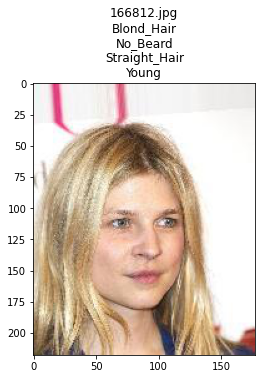

In [30]:
sample_img, sample_img_meta = show_sample_image(nb=1)


In [31]:
z = encode_image(sample_img.astype(np.float32) / 255., np.array(sample_img_meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

latent sample:
 [ 0.6052532  -1.023139   -0.79608226  3.028561   -1.3959439   2.1333413
  1.8010309   2.7751935   4.0032625   2.4709828   1.0249408  -1.4893414
 -0.05507808  1.358857   -0.19675292 -1.3421142 ]


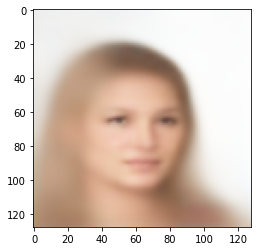

In [32]:
ret = decode_embedding(z, sample_img_meta, decoder)
plt.imshow(ret[0])
plt.show()

In [33]:
meta_cols = df_celeb.columns[1:].values
meta_cols

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [34]:
def display_manifold(decoder, height, width, base_vec, bound_x=15, bound_y=15, axis_x=0, axis_y=1, n=15,
                     desc_x = 'x', desc_y = 'y', file_out=None):
    '''
    The function takes a latent representation and 
    applies an interpolation on its values according to two conditioning attributes
    in order to generate gradual changes in the reconstructed images.
    
    Arguments:
        decoder: trained decoder
        height: height of images to generate
        width: width of images to generate
        base_vec: latent representation to use.
        bound_x: the first conditioning attribute will vary within the interval [-bound_x, +bound_x]
        bound_y: the second conditioning attribute will vary within the interval [-bound_y, +bound_y]
        axis_x: the index of the first conditioning attribute in the latent representation
        axis_y: the index of the first conditioning attribute in the latent representation
        n: n**2 images will be generated
        desc_x: the name of the first conditioning attribute
        desc_y: the name of the second conditioning attribute
        file_out: file for saving the resulting plot
        
    '''
    
    figure = np.zeros((height * (n if bound_y > 0 else 1), width * (n if bound_x > 0 else 1), 3))
    grid_x = np.linspace(-bound_x, bound_x, n) if bound_x > 0 else [0]
    grid_y = np.linspace(-bound_y, bound_y, n) if bound_y > 0 else [0]
    individual_outputs = []

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = base_vec.copy()
            z_sample[axis_x] = xi 
            z_sample[axis_y] = yi 

            x_decoded = decoder.predict(np.expand_dims(z_sample, axis=0))
            sample = np.clip(x_decoded[0], 0, 1)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = sample
            individual_outputs.append(sample)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.xlabel(desc_x)
    plt.ylabel(desc_y)
    if file_out is not None:
        plt.savefig(file_out, dpi=200, bbox_inches='tight')
    return figure, individual_outputs

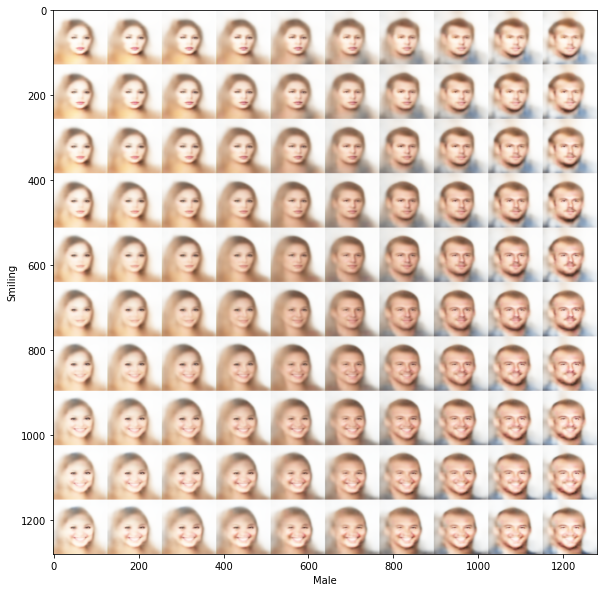

In [35]:
dim1 = 'Male'
dim2 = 'Smiling'
base_vec = np.array(list(z[0]) + sample_img_meta)
rendering, _ = display_manifold(
                                decoder, 
                                HEIGHT, 
                                WIDTH, 
                                base_vec, 
                                bound_x=15, 
                                bound_y=15, 
                                axis_x=LATENT_DIM + np.where(meta_cols==dim1)[0][0], 
                                axis_y=LATENT_DIM + np.where(meta_cols==dim2)[0][0], 
                                n=10,
                                desc_x = dim1,
                                desc_y = dim2,
                                file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png'
                                )

In [36]:
def generate_new_images_vae(nb=16, smiling=None, male=None, no_beard=None, attractive=None, 
                        bald=None, chubby=None, eyeglasses=None, young = None):
    sample_training_img, sample_training_img_meta = show_sample_image(nb=1, verbose=False)
    plt.clf();
    f, ax = plt.subplots(2, nb//2, figsize=(20,7));
    for i in range(nb):
        meta=2*np.random.rand(meta_cols.shape[0])-1
        meta[2] = attractive if attractive else meta[2]
        meta[4] = bald if bald else meta[4]
        meta[13] = chubby if chubby else meta[13]
        meta[15] = eyeglasses if eyeglasses else meta[15]
        meta[20] = male if male else meta[20]
        meta[24] = no_beard if no_beard else meta[24]
        meta[31] = smiling if smiling else meta[31]
        meta[39] = young if young else meta[39]
        z1 = np.random.rand(LATENT_DIM, LATENT_DIM)
        ret = decode_embedding(z1, meta, decoder)
        ax[i%2][i//2].imshow(ret[0])
        ax[i%2][i//2].set_title('generated img {}'.format(i))
    ax[0][0].imshow(sample_training_img)
    ax[0][0].set_title('training img')

In [37]:
def generate_new_images_ep(ep, na=4, nb=16, smiling=-6, no_beard=-8,attractive=4, eyeglasses=2):
    sample_training_img, meta = show_sample_image(nb=1, verbose=False)
    att_list = []
    for i in range(na):
        if(i<ep):
            att_list.append(1)
        else:
            att_list.append(0)
    random.shuffle(att_list)
    plt.clf();
    f, ax = plt.subplots(2, 3, figsize=(20,7));
    z1 = np.random.rand(LATENT_DIM, LATENT_DIM)
    z = encode_image(sample_training_img.astype(np.float32) / 255., np.array(meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
    ret = decode_embedding(z, meta, decoder)
    ax[0][0].imshow(sample_training_img)
    ax[0][0].set_title('training img')
    ax[0][1].imshow(ret[0])
    ax[0][1].set_title('Simple Decoded')
    if(att_list[0]==1):
        meta[2] = attractive if attractive else meta[4]
    if(att_list[1]==1):
        meta[15] = eyeglasses if eyeglasses else meta[15]
    if(att_list[2]==1):
        meta[24] = no_beard if no_beard else meta[24]
    if(att_list[3]==1):
        meta[31] = smiling if smiling else meta[31]
    ret = decode_embedding(z, meta, decoder)
    ax[0][2].imshow(ret[0])
    ax[0][2].set_title('generated img with noise')    

<Figure size 720x360 with 0 Axes>

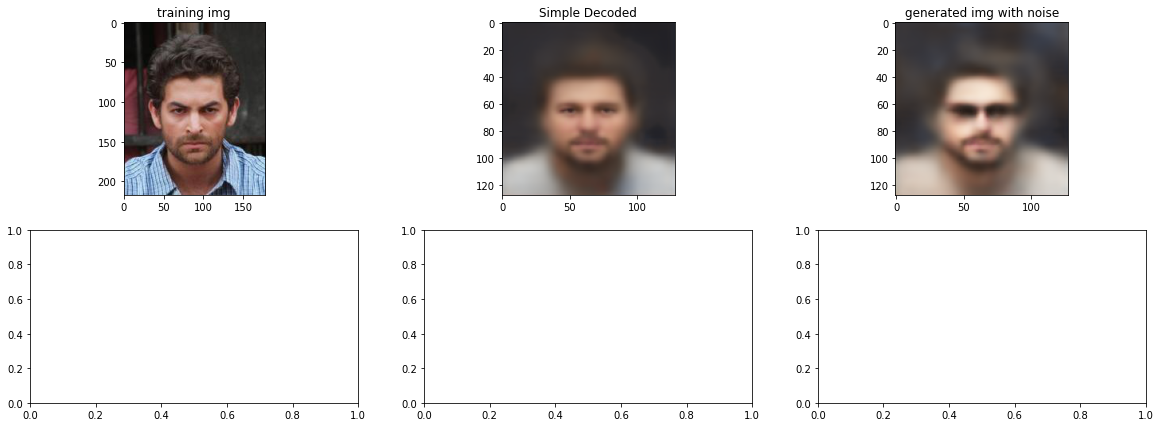

In [38]:
generate_new_images_ep(4)
